# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [1]:
!pip install nltk


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import re

In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path,encoding="utf-8") as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [4]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    return (convert_label(data_line[1]),data_line[2])

In [7]:

# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    ## This tokenizes the input by simply cutting at word boundaries, which is
    ## anything that isn't a letter, digit, or underscore.
    pattern = "\W"
    tokens = re.split(pattern, text)
    while "" in tokens:
        tokens.remove("")
    return tokens

In [8]:
##### TEST
pre_process("This is my Name..")

['This', 'is', 'my', 'Name']

# Question 2: Basic Feature Extraction (20 marks)

In [9]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    ## Simple BOW model
    features_dict = {}
    for token in tokens:
        features_dict.setdefault(token, 0)
        global_feature_dict.setdefault(token,0)
        ## Using a BOW model
        features_dict[token] += 1
        global_feature_dict[token] += 1
    return features_dict

In [10]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [11]:
#solution
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    results = []
    cv_results = {
               "FAKE":{"precision":0, "recall":0, "f1-score":0},
               "REAL":{"precision":0, "recall":0, "f1-score":0},
               "accuracy":0,
               "macro avg":{"precision":0, "recall":0, "f1-score":0},
               "weighted avg":{"precision":0, "recall":0, "f1-score":0}
              }
    
    results_headers = list(cv_results.keys())
    results_sub_headers = list(cv_results["FAKE"].keys())
    
    fold_size = int(len(dataset)/folds) + 1 
    data = np.array(dataset)
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        test = dataset[i:i+fold_size]
        test_x = []
        test_y = []
        for data in test:
            test_x.append(data[0])
            test_y.append(data[1])
        
        train = dataset[0:i]
        train.extend(dataset[i+fold_size:])
        model = train_classifier(train)
        predicted = predict_labels(test_x, model)
        report = classification_report(test_y, predicted, output_dict=True)
        
        ### Appending the results for all
        results.append(report)
        
        for header in results_headers:
            if header == "accuracy":
                cv_results[header] += report["accuracy"]/folds
                continue
            for sub in results_sub_headers:
                cv_results[header][sub] += report[header][sub]/folds
    for header in results_headers:
        if header == "accuracy":
            print(f"## {header} ## {cv_results[header]}")
            continue
        print(f"## {header} ##")
        for sub in results_sub_headers:
            print(f"{sub} : {cv_results[header][sub]}")
    return None

In [12]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [13]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset

# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
13791


In [14]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...
## FAKE ##
precision : 0.49464039435044377
recall : 0.49345984958477984
f1-score : 0.49370903622046786
## REAL ##
precision : 0.6108037155458281
recall : 0.6119902271932431
f1-score : 0.6111365838712632
## accuracy ## 0.5604523609275501
## macro avg ##
precision : 0.552722054948136
recall : 0.5527250383890114
f1-score : 0.5524228100458656
## weighted avg ##
precision : 0.5610236897944589
recall : 0.5604523609275501
f1-score : 0.5604398421160508


# 4. Error Analysis (10 marks)

In [23]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [24]:
def ErrorAnalysisWriter(dic,arr,typ):
    name = {"tp":"Q4_True_Positive.csv","fp":"Q4_False_Positive.csv",
            "tn":"Q4_True_Negative.csv","fn":"Q4_False_Negative.csv"}
    with open(name[typ],"w") as file:
        headers = list(dic.keys())
        headers.sort(key=lambda x:-dic[x])
        writer = csv.DictWriter(file,fieldnames=headers)
        writer.writeheader()
        for i in arr:
            writer.writerow(i)

In [25]:
#solution
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    ## Error Analysis
    
    fp = []
    fp_dict = {}
    fn = []
    fn_dict = {}
    tp = []
    tp_dict = {}
    tn = []
    tn_dict = {}
    
    ##
    
    
    
    results = []
    cv_results = {
               "FAKE":{"precision":0, "recall":0, "f1-score":0},
               "REAL":{"precision":0, "recall":0, "f1-score":0},
               "accuracy":0,
               "macro avg":{"precision":0, "recall":0, "f1-score":0},
               "weighted avg":{"precision":0, "recall":0, "f1-score":0}
              }
    
    results_headers = list(cv_results.keys())
    results_sub_headers = list(cv_results["FAKE"].keys())
    
    fold_size = int(len(dataset)/folds) + 1 
    data = np.array(dataset)
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        test = dataset[i:i+fold_size]
        test_x = []
        test_y = []
        for data in test:
            test_x.append(data[0])
            test_y.append(data[1])
        
        train = dataset[0:i]
        train.extend(dataset[i+fold_size:])
        model = train_classifier(train)
        predicted = predict_labels(test_x, model)
        report = classification_report(test_y, predicted, output_dict=True)
        
        
        ## Confusion Matrix
        if i==0:
            confusion_matrix_heatmap(test_y, predicted, labels=["FAKE","REAL"])
        ##
        ## Error Analysis
            for value in range(len(test_y)):
                if test_y[value]== "REAL" and predicted[value] == "FAKE":
                    for i in list(test_x[value].keys()):
                        fp_dict.setdefault(i, 0)
                        fp_dict[i]+=1
                    fp.append(test_x[value])
                elif test_y[value]== "FAKE" and predicted[value] == "REAL":
                    for i in list(test_x[value].keys()):
                        fn_dict.setdefault(i, 0)
                        fn_dict[i]+=1
                    fn.append(test_x[value])
                elif test_y[value] == "FAKE" and predicted[value] == "FAKE":
                    for i in list(test_x[value].keys()):
                        tp_dict.setdefault(i, 0)
                        tp_dict[i]+=1
                    tp.append(test_x[value])
                elif test_y[value] == "REAL" and predicted[value] == "REAL":
                    for i in list(test_x[value].keys()):
                        tn_dict.setdefault(i, 0)
                        tn_dict[i]+=1
                    tn.append(test_x[value])
            ErrorAnalysisWriter(fp_dict,fp,"fp")
            ErrorAnalysisWriter(fn_dict,fn,"fn")
            ErrorAnalysisWriter(tp_dict,tp,"tp")
            ErrorAnalysisWriter(tn_dict,tn,"tn")
        
        ##
        ### Appending the results for all
        results.append(report)
        
        for header in results_headers:
            if header == "accuracy":
                cv_results[header] += report["accuracy"]/folds
                continue
            for sub in results_sub_headers:
                cv_results[header][sub] += report[header][sub]/folds
    for header in results_headers:
        if header == "accuracy":
            print(f"## {header} ## {cv_results[header]}")
            continue
        print(f"## {header} ##")
        for sub in results_sub_headers:
            print(f"{sub} : {cv_results[header][sub]}")
            
    return None

Fold start on items 0 - 820
Training Classifier...


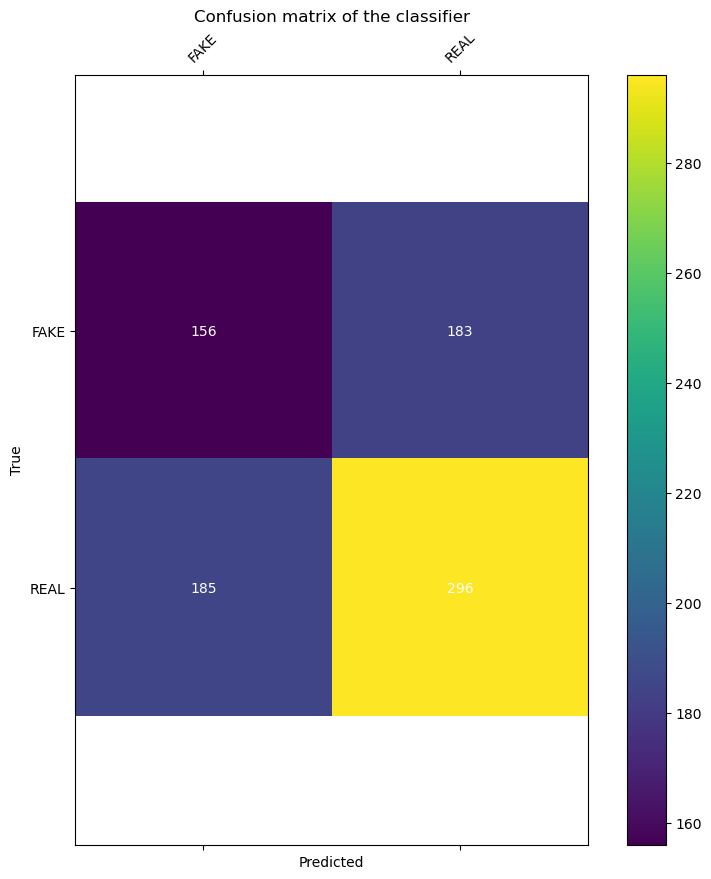

Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...
## FAKE ##
precision : 0.49464039435044377
recall : 0.49345984958477984
f1-score : 0.49370903622046786
## REAL ##
precision : 0.6108037155458281
recall : 0.6119902271932431
f1-score : 0.6111365838712632
## accuracy ## 0.5604523609275501
## macro avg ##
precision : 0.552722054948136
recall : 0.5527250383890114
f1-score : 0.5524228100458656
## weighted avg ##
precision : 0.5610236897944589
recall : 0.5604523609275501
f1-score : 0.5604398421160508


In [26]:
cross_validate(train_data, 10)